# Predicting Price of Singapore Airbnb 

## Introduction
<<< inlcude some text >>>

### Import of libraries and the data set 

In [1]:
# Imports
import math
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sn

In [2]:
# read data 
listing = pd.read_csv("listings.csv")

## 1. Descriptive Analysis

### 1.1 Overview and Cleaning Data Set

In [3]:
listing.shape
# we have 7907 observations and 16 columns

(7907, 16)

In [4]:
listing.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,49091,COZICOMFORT LONG TERM STAY ROOM 2,266763,Francesca,North Region,Woodlands,1.44255,103.79580,Private room,83,180,1,2013-10-21,0.01,2,365
1,50646,Pleasant Room along Bukit Timah,227796,Sujatha,Central Region,Bukit Timah,1.33235,103.78521,Private room,81,90,18,2014-12-26,0.28,1,365
2,56334,COZICOMFORT,266763,Francesca,North Region,Woodlands,1.44246,103.79667,Private room,69,6,20,2015-10-01,0.20,2,365
3,71609,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,East Region,Tampines,1.34541,103.95712,Private room,206,1,14,2019-08-11,0.15,9,353
4,71896,B&B Room 1 near Airport & EXPO,367042,Belinda,East Region,Tampines,1.34567,103.95963,Private room,94,1,22,2019-07-28,0.22,9,355


In [5]:
# get further details of the data types 
listing.info()
# int64 and float64 stands for numeric data, where as object denotes categorical data.
# We see that host_id is saved as a integer, yet we will need to categorize this value for our analysis
# we have 7907 air bnbs, differs from 5149 for last_review & reviews_per_month. 
# (unnecessary -> will remove from data set)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7907 entries, 0 to 7906
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              7907 non-null   int64  
 1   name                            7905 non-null   object 
 2   host_id                         7907 non-null   int64  
 3   host_name                       7907 non-null   object 
 4   neighbourhood_group             7907 non-null   object 
 5   neighbourhood                   7907 non-null   object 
 6   latitude                        7907 non-null   float64
 7   longitude                       7907 non-null   float64
 8   room_type                       7907 non-null   object 
 9   price                           7907 non-null   int64  
 10  minimum_nights                  7907 non-null   int64  
 11  number_of_reviews               7907 non-null   int64  
 12  last_review                     51

In [6]:
# removing columns
listing = listing.drop(["name", "host_name", "last_review"], axis = 1)
# axis = 1 --> column

In [7]:
# remove NA values
listing = listing.dropna(how ="any", axis=0)  
# use any so it drops any kind of null value 
# axis = 0 --> row

In [8]:
# rename column "calculated_host_listings_count"
listing = listing.rename(columns={"calculated_host_listings_count": "listings_count"})

In [9]:
# transform id and host_id into categorical values
listing["id"] = listing.id.apply(lambda x: str(x))
listing["host_id"] = listing.host_id.apply(lambda x: str(x))

In [10]:
# check for duplicates 
duplications = sum(listing.duplicated("id"))
print("We have", duplications, "duplications of Airbnb offers.")

We have 0 duplications of Airbnb offers.


In [11]:
listing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5149 entries, 0 to 7767
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   5149 non-null   object 
 1   host_id              5149 non-null   object 
 2   neighbourhood_group  5149 non-null   object 
 3   neighbourhood        5149 non-null   object 
 4   latitude             5149 non-null   float64
 5   longitude            5149 non-null   float64
 6   room_type            5149 non-null   object 
 7   price                5149 non-null   int64  
 8   minimum_nights       5149 non-null   int64  
 9   number_of_reviews    5149 non-null   int64  
 10  reviews_per_month    5149 non-null   float64
 11  listings_count       5149 non-null   int64  
 12  availability_365     5149 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 563.2+ KB


In [12]:
listing.head()

,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,listings_count,availability_365
0,49091,266763,North Region,Woodlands,1.44255,103.79580,Private room,83,180,1,0.01,2,365
1,50646,227796,Central Region,Bukit Timah,1.33235,103.78521,Private room,81,90,18,0.28,1,365
2,56334,266763,North Region,Woodlands,1.44246,103.79667,Private room,69,6,20,0.20,2,365
3,71609,367042,East Region,Tampines,1.34541,103.95712,Private room,206,1,14,0.15,9,353
4,71896,367042,East Region,Tampines,1.34567,103.95963,Private room,94,1,22,0.22,9,355


We have successfully transformed "id" & "host_id" into categorical data and removed duplicated and unnecessary columns. Hence, we are now left with 5149 rows and 13 columns. 

### 1.2 Univariate Analysis

Taking a closer look at each single variable.

In [13]:
# make two lists for both numerical and categorical variables

def get_variable_type():   
     # numerical variables
    num_variables = listing.select_dtypes(include=["int64","float64"]).columns

    # categorical variables
    cat_variables = listing.select_dtypes(include=["object"]).columns
    cat_variables = cat_variables.drop(["id","host_id"])
    return list(num_variables), list(cat_variables)

num_variables, cat_variables = get_variable_type()

#### Numerical Data

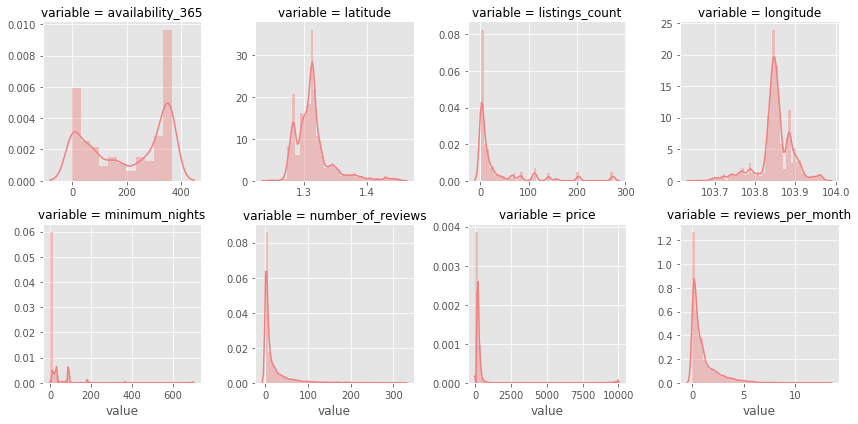

In [15]:
# distribution plots of all numerical variables

num_melt = pd.melt(listing, value_vars=sorted(num_variables))
num_grid = sn.FacetGrid(num_melt, col="variable", col_wrap=4, sharex=False, sharey=False)
num_grid = num_grid.map(sn.distplot, "value", color = "lightcoral")

Let's take a closer look at our dependent variable price

In [16]:
# price
listing.price.describe()

count     5149.000000
mean       151.295203
std        253.805616
min          0.000000
25%         62.000000
50%        115.000000
75%        187.000000
max      10000.000000
Name: price, dtype: float64

In [17]:
listing.price.median()

# median < mean -> indicates positive skewness
# huge outlier with max price of 10000, 75% of offers included in range to price of 187

115.0

In [18]:
print("Skew: {:.2f} | Kurtosis: {:.2f}".format(listing.price.skew(), listing.price.kurtosis()))

# extreme high kurtosis (very spikey), strong positive skew -> (right skewed)

Skew: 27.45 | Kurtosis: 990.18


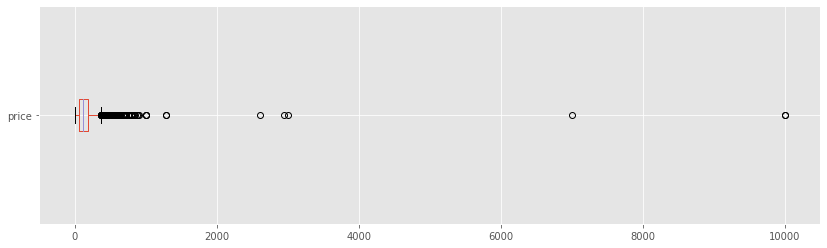

In [19]:
plt.figure(figsize=(14,4))
listing.price.plot.box(vert = False)
plt.show()

# several potential outliers observable

In [20]:
# number of reviews
listing.number_of_reviews.describe()

count    5149.000000
mean       19.667508
std        34.934534
min         1.000000
25%         2.000000
50%         6.000000
75%        21.000000
max       323.000000
Name: number_of_reviews, dtype: float64

In [21]:
listing.number_of_reviews.median()

# median of 6 and mean of 19.67 suggest a right skewed distribution

6.0

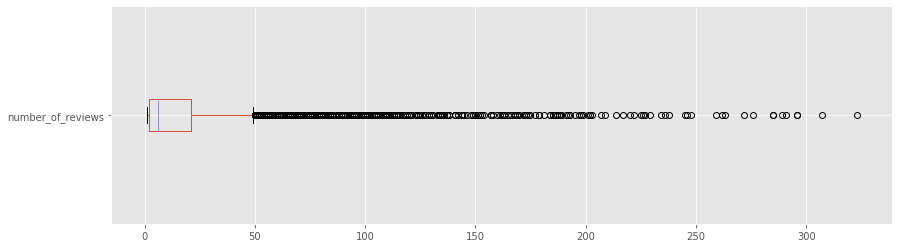

In [22]:
plt.figure(figsize=(14,4))
listing.number_of_reviews.plot.box(vert = False)
plt.show()
# strongly right skewed

In [29]:
# listings_count and host_id
l_count = listing.sort_values("listings_count").drop_duplicates(["host_id"])
l_count = l_count[["host_id", "listings_count"]]
l_count.sort_values("listings_count", ascending =False).head(15)

# apparently we have many individuals that offer dozens if not hundreds of Airbnb 

,host_id,listings_count
5235,66406177,274
1852,8492007,203
5053,209913841,157
4484,29420853,141
4621,31464513,114
6355,219550151,113
1785,2413412,112
3754,108773366,109
1589,23722617,84
6598,8948251,83


#### Categorical Data

/Users/Dada/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


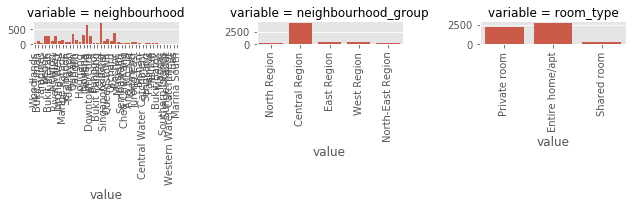

In [30]:
cat_melt = pd.melt(listing, value_vars=sorted(cat_variables))
cat_grid = sn.FacetGrid(cat_melt, col="variable", col_wrap=4, sharex=False, sharey=False)
plt.xticks(rotation="vertical")
cat_grid = cat_grid.map(sn.countplot, "value")
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in cat_grid.axes.flat]
cat_grid.fig.tight_layout()
plt.show()

In [ ]:
#region 
listing.neighbourhood_group.hist(bins = 5, rwidth =.9, color="lightcoral")

In [ ]:
# neighbourhood
listing.neighbourhood.value_counts()

In [ ]:
# rooms
listing.room_type.value_counts()

In [ ]:
listing.room_type.hist(bins=3, rwidth=.8, color="lightcoral")
plt.show()

# mostly entire homes/apartments closely followed by private rooms

We can see that many of our variables contain many potential outliers and thus the distribution is heavily skewed. But as of now this isn't and issue to worry about. 

### 1.3 Bivariate Analysis

## 2. Prediction

### 2.1 Prepare data

In [ ]:
# Log transform of the skewed numerical features to lessen impact of outliers
# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

### 2.2 Linear Regression

### 2.3 Ridge

### 2.4 Lasso

## 3. Conclusion